# Bibliothek von verschiendenen Referenztrajektoriengeneratoren (optimiert)

**(2. Übung Flachheit, Aufgabe 3)**

Im Gegensatz zu den Implementierungen in den Aufgaben 1 und 2 werden hier folgende Dinge modifiziert bzw. optimiert:

- Bereits in der Basisklasse erfolgt das Handling der stationären Regimes. In den abgeleiteten Klasse ist damit nur noch der Übergang von 0 auf 1 auf dem Intervall (0, 1) zu implementieren. Der Offset, die Skalierung und die inneren Ableitungen erfolgt automatisch in der Basisklasse. Dies geschieht in der Methode `transfer`.
- Die Transferfunktion ist vektoriell. Skalare Zeitargumente werden automatisch in der Basisklasse entsprechend angepasst.
- Auswertung der Trajektorie über den `__call__`-Operator, also einfach durch den Aufruf `MyTrajGen(t)`.
- Polynomauswertung mittels Horner Schema anstelle der NumPy-Polynomial-Klasse.

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/flavert-nbviewer-content

**Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!**

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>


---

## Import der benötigten Module

In [1]:
import numpy as np
import scipy.special as scs
import abc
import matplotlib.pyplot as plt
from typing import Union  # Für type-annotations in Python < 3.10

## Definition der abstrakten Basisklasse

In [2]:
class TrajGenBase(abc.ABC):
    """ Abstrakte Basisklasse für alle Trajektoriengeneratoren.

    Abgeleitete Klassen müssen die Methode transfer implementieren, die den Übergang
    von 0 auf 1 auf dem Zeitintervall (0, 1) realisiert. Offset, Skalierung und innere
    Ableitungen werden automatisch durch die Methoden der Basisklasse realisiert.

    """

    def __init__(self, t_start: float, t_end: float, y_start: float, y_end: float, max_deriv: int):
        """ Konstruktion eines Trajektoriengeneratorobjektes.

        Args:
            t_start: Startzeitpunkt des Übergangs
            t_end: Endezeitpunkt des Übergangs
            y_start: Stationärer Anfangswert
            y_end: Stationärer Endwert
            max_deriv: Maximal mögliche Ableitung, glatte Ableitung. Auf np.NaN setzen, wenn
                       Trajektorie unendlich oft stetig differenzierbar.
        """
        self.t0 = t_start
        """ Der Startzeitpunkt des Übergangs"""

        self.t1 = t_end
        """ Der Endzeitpunkt des Übergangs"""

        self.y0 = y_start
        """ Der stationäre Anfangswert """

        self.y1 = y_end
        """ Der Stationäre Endwert"""

        self.max_deriv = max_deriv
        """ Die höchstmggliche stetig diffbare Ableitung (auf np.NaN setzen wenn unendlich oft diffbar) """

        self.delta_t = t_end - t_start
        """ Die Zeitspanne des Übergangs """

        self.delta_y = y_end - y_start
        """ Dei Differenz zwischen Anfangs- und Endwert des Übegangs """

    def __call__(self, t: Union[float, np.ndarray[float], list[float], tuple[float]],
                 num_derivs: int = -1) -> np.ndarray[float]:
        """ Auswertung der Trajektorie für einen Zeitpunkt oder eine Folge von Zeitpunkten

        Standardmäßig werden bei endlich oft stetig differenzierbaren Trajektorien alle stetig
        diffbaren Ableitungen zurückgegeben, bei unendlich oft stetig differenzierbaren Trajektorien
        nur der Absolutwert (0.te Ableitung). Das Verhalten kann mit dem Parameter num_derivs
        justiert werden.

        Args:
            t: Ein einzelner Zeitwert oder ein(e) numpy.ndarray, Liste oder Tupel von N Zeitwerten
            num_derivs (optional): Anzahl der gewünschten Ableitungen.
                                  num_derivs = -1: Bei endlich oft stetig differenzierbaren Trajektorien:
                                                   Rückgabe bis zur höchsten Ableitung, die nicht springt
                                                   Bei unendlich oft stetig differenzierbaren Trajektorien:
                                                   Nur Rückgabe des Absolutwertes
                                  Wenn bei endlich stetig differenzieraren Trajektorien num_derivs größer
                                  gewählt wird als max_deriv bei der Instanzierung, dann werden nur
                                  max_deriv Ableitungen zurückgegeben.

        Returns:
            Im Falle eines Zeitpunktes: Ein 1D-numpy.ndarray mit m+1 Elementen,
            dessen i.tes Element die i.te Ableitung der Trajektorie zum gegebenen Zeitpunkt
            enthält.
            Im Falle einer Folge von Zeitwerten: Ein 2D-numpy.ndarray mit m+1 Zeilen und
            N Spalten. Die i.te Spalte enthält den Wert und die m Ableitungen zum Zeitpunkt
            t[i].

        ToDo:
            Ändere "Union[float, np.ndarray[float], list[float]])" in
            "float | p.ndarray[float] | list[float]" wenn Python 3.9 Unterstützung aufgegeben wird.
        """
        if np.isscalar(t):
            return self.eval(np.atleast_1d(t), num_derivs)[:, 0]
        else:
            return self.eval(np.asarray(t), num_derivs)

    def eval(self, t: np.ndarray[float], num_derivs=-1) -> np.ndarray[float]:
        """ Wertet die Referenztrajektorie für eine Folge von Zeitpunkten aus

        Args:
            t: Gewünschte Auswertezeitpunkte (N Stück)
            num_derivs: Anzahl der gewünschten Ableitungen. Siehe Docstring der __call__ Methode.

        Returns:
            2D numpy.ndarray mit m+1 Zeilen und N Spalten. Die i.te Zeile
            enthält die i.te Ableitung der Referenztrajektorie
            zu den in t definierten Zeitpunkten.
        """
        if np.isnan(self.max_deriv):
            maxderiv = 0 if (num_derivs <= 0) else num_derivs
        else:
            maxderiv = self.max_deriv if (num_derivs < 0) or (num_derivs > self.max_deriv) else num_derivs

        y_mat = np.zeros((maxderiv + 1, t.size))

        # Alles für t < t0
        y_mat[0, t <= self.t0] = self.y0

        # Alles für t > t1
        y_mat[0, t >= self.t1] = self.y1

        # Indizes in t (= Spalten in y_mat) und Zeitwerte für den Polynomübergang
        inds_for_transfer = (t > self.t0) & (t < self.t1)
        t_for_transfer = (t[inds_for_transfer] - self.t0) / self.delta_t

        # Skalierter Übergang
        y_mat[:, inds_for_transfer] = self.delta_y * self.transfer(t_for_transfer, maxderiv)

        # Offset
        y_mat[0, inds_for_transfer] += self.y0

        # Innere Ableitung
        dt_power_i = 1.0
        for i in range(1, maxderiv + 1):
            dt_power_i *= self.delta_t
            y_mat[i, inds_for_transfer] /= dt_power_i

        return y_mat

    @abc.abstractmethod
    def transfer(self, t: np.ndarray[float], maxderiv: int) -> np.ndarray[float]:
        """ Implementiert den Übergang von 0 auf 1 auf dem offenen Intervall (0, 1)

        Diese Methode ist in abgeleiteten Klassen zu überschreiben.

        Die stationären Werte für t = 0 und t = 1 werden bereits in der eval-Methode
        bestimmt.

        Args:
            t: Array mit N Zeitwerten aus dem offenen Intervall (0, 1)
            maxderiv: höchste gewünschte Ableitungsordnung m

        Returns:
            Ein 2D-Array mit m+1 Zeilen (Absolutwert und Ableitungen) und N Spalten (Zeitpunkte).
        """
        ...

## Implementierung der auf einer Prototypenfunktion basierenden Trajektorie

Nachfolgend wird eine Implementierung vorgestellt, die auf die Nutzung der NumPy-Polynom-Klasse verzichtet (siehe Aufgaben 1 + 2),
sondern stattdessen das Horner Schema verwendet. Man handelt sich dann nicht den Overhead der Polynom-Klasse ein, allerdings
muss man auch selber implementieren und testen. Evtl. ist das effektiver in der Ausführung, ggf. dauert es aber länger,
bis man alles am Laufen hat. Die übliche Abwägungsproblematik halt...

### Horner Schema

Es ist verlockend, ein Polynom 

\begin{equation*}
y = c_0 + c_1 x + c_2 x^2 + c_3 x^3
\end{equation*}

durch direkte Implemtierung der Potenzen zu implementieren:

```Python
y = c[0] + c[1] * x + c[2] * x**2 + c[3] * x**3
```

Das ist jedoch nicht sonderlich effektiv. Stattdessen macht man sich zu Nutze, dass man das Polynom auch so schreiben kann:

\begin{equation*}
y = c_ 0 + (c_1 + (c_2 + c_3 \cdot (x) ) \cdot x) \cdot x
\end{equation*}

Dies lässt sich rekursiv für n+1 Koeffizienten einfach implementieren (Pseudocode)
```
    y = 0
    for i = n down to 0:
       y = c[i] + y * x
```

Die Ableitungen kann man dann auch gleich noch mit abfrühstücken: Aus der Rekursionszeile $c_i +  y \cdot x$ folgt durch sukzessives Ableiten:

\begin{align*}
    y^\prime &= y^\prime \cdot x + y\\
    y^{\prime\prime} &= y^{\prime\prime} \cdot x + 2 y^\prime\\
    y^{(3)} &= y^{(3)} \cdot x + 3 y^{\prime\prime}\\
    &\vdots\\
    y^{(n)} &= y^{(n)} \cdot x + n y^{(n-1)}
\end{align*}

Für ein Polynom dritten Grades lassen sich dann bspw. die ersten zwei Ableitungen und der Funktionswert wie folgt berechnen:
```Python
y = 0
ydot = 0
yddot = 0
for i in range(n, -1, -1)  # n, n-1, ..., 1, 0
    yddot = yddot * x + 2 * ydot
    ydot = ydot * x + y
    y = c[i] + y * x
```

Allgemein erhält man für die ersten k Ableitungen (`y[i]` enthält die i.te Ableitung):
```Python
y = np.zeros(k)
for i in range(c.size-1, -1, -1):
    for j in range(k, 0, -1):
        y[j] = y[j] * x + j * y[j-1]
    y[0] = c[i] + y[0] * x
```

In [3]:
class TrajGenProto(TrajGenBase):
    """ Trajektoriengenerator auf Basis einer Prototypenfunktion

    Die Prototypenfunktion wird mittels Horner-Schema ausgewertet.

    Realisiert einen Übergang von einem stationären Wert y_start zu
    einem stationären Wert y_end auf dem Zeitintervall t_end - t_start.
    Die zugehörige Funktion ist smooth_to mal stetig differenzierbar.

    Args:
        t_start: Startzeitpunkt des Übergangs
        t_end: Endzeitpunkt des Übergangs
        y_start: Startwert des Übergangs
        y_end: Endwert des Übergangs
        smooth_to: Maximale Ableitungsordnung, die nicht springt.
    """

    def __init__(self, t_start: float, t_end: float, y_start: float, y_end: float, smooth_to: int):

        # Basisklasse initialisieren
        super().__init__(t_start, t_end, y_start, y_end, smooth_to)

        # Polynomkoeffizienten für Berechnung des Übergangs und der Ableitungen aufsetzen
        self.c = self.setup_coeffs(smooth_to)
        """ Die Koeffizienten des den Übergang bescheibenden Polynoms """

    @staticmethod
    def setup_coeffs(gamma: int) -> np.ndarray[float]:
        """ Hilfsmethode zum Bestimmen der Koeffizienten für das Polynom.

        Realisiert wird ein Übergang von 0 auf 1 auf dem Intervall (0, 1)

        Args:
            gamma: Maximale Ableitungsordnung, die nicht springt

        Returns:
            numpy.ndarray mit 2*(gamma+1) Koeffizienten c0 = c[0], c1 = c[1], ...
        """

        # Hilfsgrößen (siehe Formel)
        alpha = scs.factorial(2 * gamma + 1)
        alpha_gamma = alpha / (scs.factorial(gamma)**2)

        # Koeffizientenvektor (die Koeffizienten 0 bis gamma sind 0!)
        coeffs = np.zeros(2 * gamma + 2)
        for k in range(0, gamma + 1):
            coeffs[gamma + 1 + k] = alpha_gamma * scs.binom(gamma, k) * (-1)**k / (gamma + k + 1)

        return coeffs

    @staticmethod
    def horner(c: np.ndarray[float], x: Union[float, np.ndarray[float]], gamma: int) -> np.ndarray[float]:
        """ Auswertung des Horner Schemas, einschl. Ableitungen

        Wertet das Polynom

        y(x) = c0 + c1 * x + c2 * x^2 + ... + cn * x^n

        und dessen erste gamma Ableitungen an der Stelle x aus.

        Args:
            c: Array mit n+1 Koeffizienten des Polynoms c[0], c[1], ..., c[n]
            x: Zeitpunkt oder Array von Zeitpunkten, an denen ausgewertet werden soll
            gamma: höchste Ableitung, bis zu der ausgewertet werden soll

        Remarks:
           x: Union[float, np.ndarray[float]] kann durch x: float | np.ndarray[float] in Python >= 3.10
           ersetzt werden
        """
        # Initialisierungen
        y = np.zeros((gamma+1, x.size))

        # Horner Schema
        for i in range(c.size-1, -1, -1):  # endet bei 0 !
            # Ableitungen
            for j in range(gamma, 0, -1):  # endet bei 1 !
                y[j] = y[j] * x + j * y[j-1]
            # Absolutwert
            y[0] = c[i] + y[0] * x

        return y

    def transfer(self, t: np.ndarray[float], maxderiv: int) -> np.ndarray[float]:
        return self.horner(self.c, t, maxderiv)

## Implementierung der Trajektorie auf Basis eines Polynomansatzes

Das Vorgehen wurde in Aufgabe 2 erläutert. Hier erfolgt nur die Anpassung an die neue Struktur der Basisklasse

In [4]:
class TrajGenPoly(TrajGenProto):
    """ Trajektoriengenerator auf Basis eines Polynoms

    Die Polynomkoeffizienten werden durch Lösung eines linearen
    Gleichungssystems bestimmt. Äquivalent mit TrajGenProto.

    Realisiert einen Übergang von einem stationären Wert y_start zu
    einem stationären Wert y_end auf dem Zeitintervall t_end - t_start.
    Die zugehörige Funktion ist smooth_to mal stetig differenzierbar.

    Args:
        t_start: Startzeitpunkt des Übergangs
        t_end: Endzeitpunkt des Übergangs
        y_start: Startwert des Übergangs
        y_end: Endwert des Übergangs
        smooth_to: Maximale Ableitungsordnung, die nicht springt.
    """

    def __init__(self, t_start: float, t_end: float, y_start: float, y_end: float, smooth_to: int):
        super().__init__(t_start, t_end, y_start, y_end, smooth_to)

    @staticmethod
    def setup_coeffs(gamma: int) -> np.ndarray[float]:

        def build_t_matrix(t, n, m):

            t_mat = np.zeros((n, m))

            # Erste Zeile
            t_mat[0, 0] = 1.0
            for i in range(1, m):
                t_mat[0, i] = t_mat[0, i - 1] * t / i

            # Restliche n-1 Zeilen
            for j in range(1, n):
                t_mat[j, j:m] = t_mat[0, 0:m - j]

            return t_mat

        # Vektor der Anfangs- und Endwerte
        y0_vec = np.zeros(gamma + 1)
        y1_vec = np.zeros(gamma + 1)
        y1_vec[0] = 1.0
        y_0_1_vec = np.append(y0_vec, y1_vec)  # 2*(gamma+1) Zeilen, 1 Spalte

        # Matrix mit den t-Potenzen
        t0_mat = build_t_matrix(0.0, gamma + 1, 2*gamma + 2)  # gamma+1 Zeilen, 2*(gamma+1) Spalten
        t1_mat = build_t_matrix(1.0, gamma + 1, 2 * gamma + 2)  # gamma+1 Zeilen, 2*(gamma+1) Spalten
        t_0_1_mat = np.append(t0_mat, t1_mat, axis=0)  # 2*(gamma+1) Zeilen, 2*(gamma+1) Spalten

        coeffs = np.linalg.solve(t_0_1_mat, y_0_1_vec)
        fac = 1.0
        for k in range(1, coeffs.size):
            fac = fac * k
            coeffs[k] = coeffs[k] / fac

        return coeffs

## Implementierung der Trajektorie auf Basis einer Gevrey-Funktion

Das Vorgehen wurde ebenfalls in Aufgabe 2 besprochen

In [5]:
class TrajGenTanh(TrajGenBase):
    """ Trajektoriengenerator mit Gevrey-Funktion

    Realisiert einen Übergang von y_start nach y_end auf dem Zeitintervall
    t_end - t_start unter Nutzung der Funktion

    f(x) = y_start + (y_end - y_start) * tanh( (2*(2x - 1)) / (4*x*(1-x))^gamma)

    mit x = (t - t_start) / (t_end - t_start)

    f(x) ist unendlich oft stetig differenzierbar
    """

    def __init__(self, t_start, t_end, y_start, y_end, gamma):
        super().__init__(t_start, t_end, y_start, y_end, np.NaN)
        self.gamma = gamma

    @staticmethod
    def y_tanh(t: np.ndarray[float], n: int, sigma: float) -> np.ndarray[float]:
        """ Implementiert y = tanh(2*(2*t-1)/(4*t*(1-t))**sigma)

        Returns:
            numpy.ndarray mit n+1 Elementen, enthält den Wert von y und dessen n Ableitungen
        """
        # Initialisierung Rückgabe
        yt = np.zeros((n + 1, t.size))

        # Einführung einiger häufig genutzter Terme
        s1 = sigma - 1  # Term sigma - 1
        t1 = t * (1 - t)  # Term t*(1-t)
        t2 = 2 * t - 1  # Term 2*t - 1

        # Terme a(t), a^{(1)}(t), ..., a^{(n+1)}(t) berechnen
        a = np.zeros((n + 2, t.size))
        a[0, :] = ((4 * t1) ** (-s1)) / (2 * s1)
        a[1, :] = (t2 * s1 / t1) * a[0, :]
        for i in range(2, n + 2, 1):  # läuft von 2 bis n+1
            a[i, :] = ((s1 + i - 1) * t2 * a[i - 1, :] + (i - 1) * (2 * s1 + i - 2) * a[i - 2, :]) / t1

        # Absolutwert von y_tanh
        yt[0, :] = np.tanh(a[1, :])

        # Ableitungen von y_tanh, wenn gewünscht
        if n > 0:
            # Initialisierung der Rekursionen
            z = np.zeros((n, t.size))
            z[0, :] = 1 - yt[0, :] ** 2
            yt[1, :] = a[2, :] * z[0, :]

            # Auswertung der Summen
            for i in range(2, n + 1, 1):
                z[i - 1, :] = 0
                for k in range(0, i, 1):
                    z[i - 1, :] -= scs.binom(i - 1, k) * yt[k, :] * yt[i - 1 - k, :]  # braucht y[0] ... y[i-1]

                for k in range(0, i, 1):
                    yt[i, :] += scs.binom(i - 1, k) * a[k + 2, :] * z[i - 1 - k, :]  # braucht z[0] ... z[i-1]

        return yt

    def transfer(self, t: np.ndarray[float], maxderiv: int) -> np.ndarray[float]:
        y = 0.5 * self.y_tanh(t, maxderiv, self.gamma)
        y[0, :] += 0.5
        return y

## Durchführung des Tests

### Implementierung der Testfunktionen

(es wird nur die Korrektheit der Ableitungen geprüft)

In [6]:
def plot_t_y(t, y):
    fig, ax = plt.subplots(4, 1, sharex=True)

    ax[0].plot(t, y[0, :])
    ax[0].set_ylabel("$y$")

    ax[1].plot(t, y[1, :])
    ax[1].set_ylabel("$\\dot y$")

    ax[2].plot(t, y[2, :])
    ax[2].set_ylabel("$\\ddot y$")
    ax[2].set_xlabel("$t$")

    ax[3].plot(t, y[3, :])
    ax[3].set_ylabel("$y^{(3)}$")
    ax[3].set_xlabel("$t$")


def verify_t_y(t, y, plot_diffs=False):
    ydot_num = np.diff(y[0, :], n=1)/(t[1] - t[0])
    yddot_num = np.diff(y[0, :], n=2)/(t[1] - t[0])**2
    ydddot_num = np.diff(y[0, :], n=3) / (t[1] - t[0]) ** 3

    fig, ax = plt.subplots(3, 1)
    if not plot_diffs:
        ax[0].plot(t[0:-1], y[1, 0:-1], t[0:-1], ydot_num)
        ax[0].legend(["Generator", "numerisch"])
        
        ax[1].plot(t[0:-2], y[2, 0:-2], t[0:-2], yddot_num)
        
        ax[2].plot(t[0:-3], y[3, 0:-3], t[0:-3], ydddot_num)
    else:
        ax[0].plot(t[0:-1], y[1, 0:-1] - ydot_num)
        ax[1].plot(t[0:-2], y[2, 0:-2] - yddot_num)
        ax[2].plot(t[0:-3], y[3, 0:-3] - ydddot_num)

    ax[0].set_title("1. Ableitung (Vergleich)")
    ax[1].set_title("2. Ableitung (Vergleich)")
    ax[2].set_title("3. Ableitung (Vergleich)")

    fig.subplots_adjust(hspace=0.4)
    
def do_test(tg: type[TrajGenBase], scalar: bool):
    t = np.arange(tg.t0 - 2.0, tg.t1 + 2.0, 0.01)
    
    if scalar:
        y = np.zeros([4, t.size])
        for i, t_val in enumerate(t):
            x = tg(t_val, 3)
            y[:, i] = tg(t_val, 3)
    else:
        y = tg(t, 3)
    
    plot_t_y(t, y)
    verify_t_y(t, y)

## Festlegen, ob die vektorisierte oder skalare Auswertung getestet wird

In [7]:
test_scalar = False

### Für die Klasse TrajGenProto:

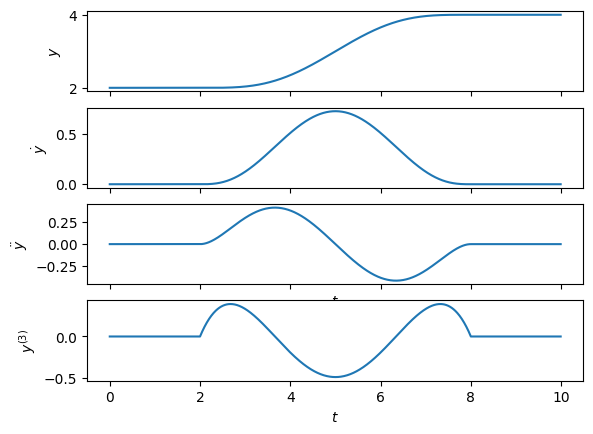

In [8]:
do_test(TrajGenProto(2, 8, 2, 4, 3), scalar=test_scalar)

## Für die Klasse TrajGenPoly

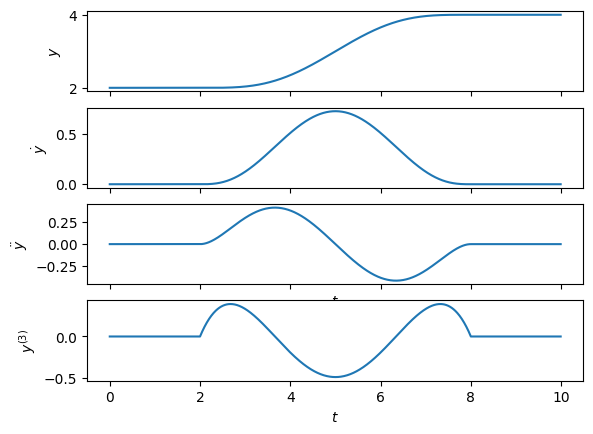

In [9]:
do_test(TrajGenPoly(2, 8, 2, 4, 3), scalar=test_scalar)

## Für die Klasse TrajGenTanh

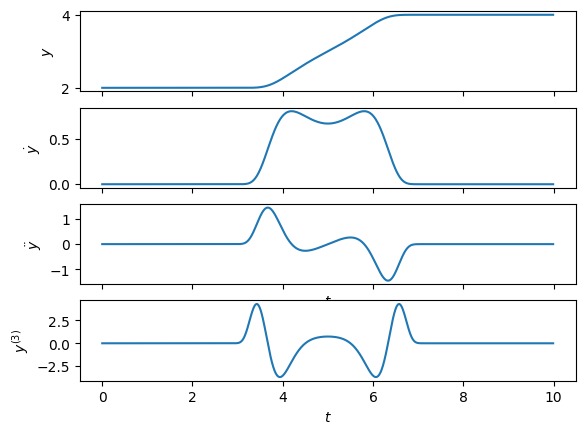

In [10]:
do_test(TrajGenTanh(2, 8, 2, 4, 3), scalar=test_scalar)